In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from pycbc.types import timeseries
from calcwf import gen_wf, chirp2total, total2chirp, match_h1_h2, match_hn, get_h, match_s_f_max, match_true_anomaly

In [3]:
sample_rate = 4096

# Plot functions

In [13]:
def chirp_match_data(e, chirp_vals, n, fiducials, f_low, approximant='TEOBResumS'):

     # Setup match dict and calculate conversion from chirp to total mass
    matches = {'diff_phase':[], 'quad':[]}
    for i in range(n):
            matches[f'h{i+1}'] = []
            matches[f'h{i+1}_phase'] = []
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Generate fiducial waveform
    all_wfs = list(get_h([1]*n, f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant))
    wf_hjs = all_wfs[1:n+1]

    # Progress bar setup
    progress = 0
    gridsize = len(chirp_vals)
    
    # Loop over chirp mass values
    for chirp in chirp_vals:
        s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)
        match_cplx = match_hn(wf_hjs, s, f_low)

        # Save matches
        match_quad_sqrd = 0
        for i in range(n):
            matches[f'h{i+1}'].append(abs(match_cplx[i]))
            matches[f'h{i+1}_phase'].append(np.angle(match_cplx[i]))
            match_quad_sqrd += abs(match_cplx[i])**2
        matches['diff_phase'].append(np.angle(match_cplx[0]) - np.angle(match_cplx[1]))
        matches['quad'].append(np.sqrt(match_quad_sqrd))

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [26]:
# Plots match contours on eccentricity/chirp mass plot
def chirp_match_plot(e, chirp_vals, n, fiducials, matches):

    # Make contour plot for  each match
    keys = [f'h{i+1}' for i in range(n)]
    keys.append('quad')
    for i, key in enumerate(keys):

        # Plotting amplitude of matches against chirp mass
        plt.plot(chirp_vals, matches[key])
        plt.axvline(fiducials[1], c='k', ls='dashed', zorder=5, alpha=0.7)
        ylim = plt.gca().get_ylim()
        plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
        plt.ylim(ylim)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('match')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.xlim(chirp_vals[0], chirp_vals[-1])
        plt.show()

    # Plot h2/h1 ratio contours
    plt.plot(chirp_vals, np.array(matches['h2'])/np.array(matches['h1']))
    plt.axvline(fiducials[1], c='k', ls='dashed', zorder=5, alpha=0.7)
    ylim = plt.gca().get_ylim()
    plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
    plt.ylim(ylim)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('match')
    plt.title(f'h2/h1, q={fiducials[2]}')
    plt.xlim(chirp_vals[0], chirp_vals[-1])
    plt.show()

In [19]:
dataslot_0 = chirp_match_data(0.1, np.linspace(23,25,101), 2, [0.1, 24, 2], 10)

101 done out of 101

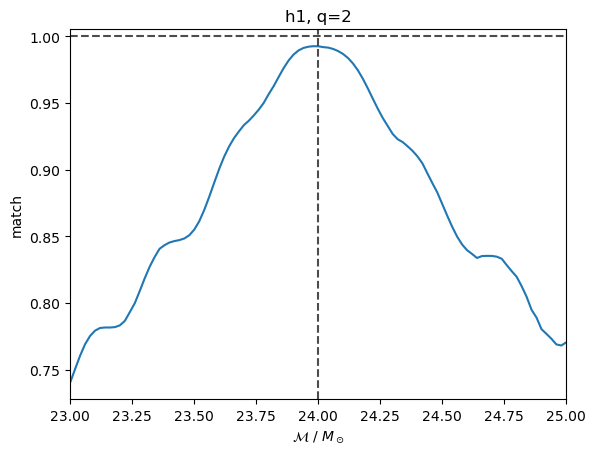

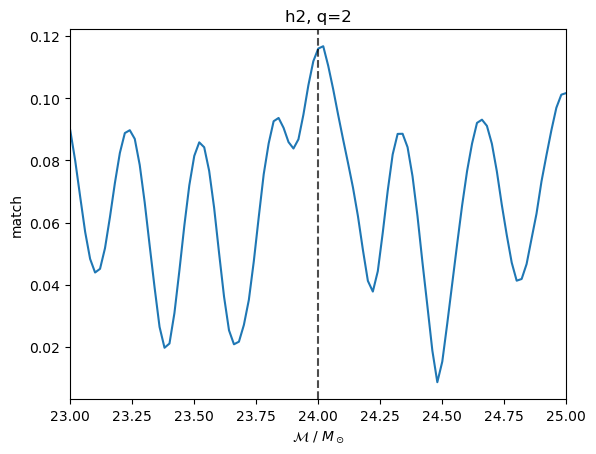

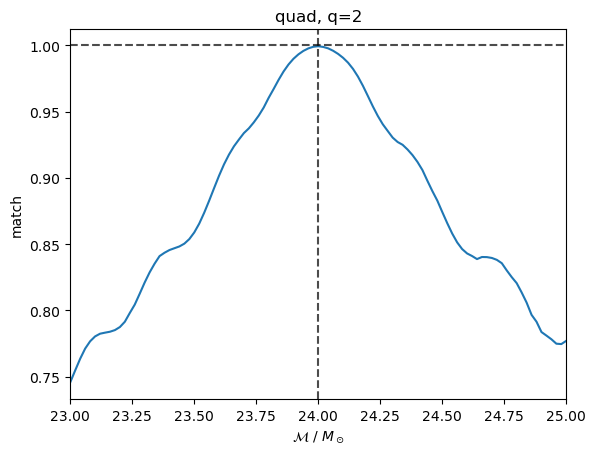

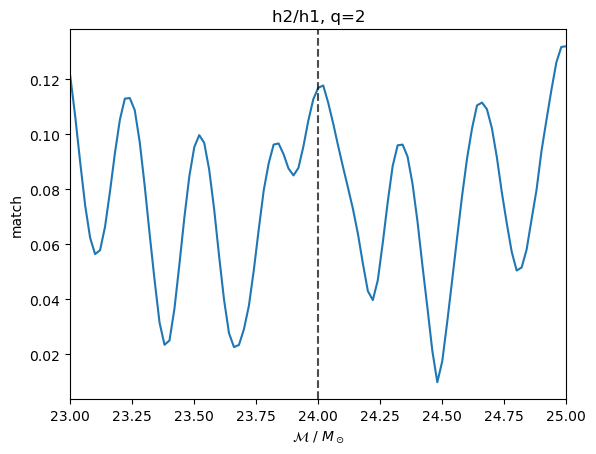

In [27]:
chirp_match_plot(0.1, np.linspace(23,25,101), 2, [0.1, 24, 2], dataslot_0)